# Proyecto Final 

In [65]:
import pandas as pd
import numpy as np
import tensorflow as tf
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz, DecisionTreeClassifier
import pandas as pd
from sklearn import svm
from math import sqrt, pi, exp
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.utils import resample



sns.set(style="darkgrid")
if tf.__version__.startswith("2."):
  import tensorflow.compat.v1 as tf
  tf.compat.v1.disable_v2_behavior()
  tf.compat.v1.disable_eager_execution()



In [3]:
# Carga de datos
all_data = pd.read_csv('data_titanic_proyecto.csv')
# Cada vez que se vuelvan a cargar los datos, necesitaremos volver a transformar
transformed_categoric = False

## Análisis exploratorio y limpieza de datos

Buscaremos valores faltantes en todo el dataset para saber si se espera tener que realizar imputación. 

In [4]:
all_data.isna().sum()

PassengerId             0
Name                    0
Age                   177
SibSp                   0
Parch                   0
Ticket                  0
Fare                    0
Cabin                 687
Embarked                2
passenger_class         0
passenger_sex           0
passenger_survived      0
dtype: int64

Vemos que Cabin tiene muchos valores faltantes, por lo que sería difícil realizar imputación, pero podemos utilizar estadística descriptiva para rellenar los valores faltantes en Age y Embarked.

Veamos una muestra del data set para familiarizarnos con las variables

In [5]:
all_data.sample(4)

,PassengerId,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,passenger_class,passenger_sex,passenger_survived
313,314,"Hendekovic, Mr. Ignjac",28.0,0,0,349243,7.8958,NaN,S,Lower,M,N
139,140,"Giglio, Mr. Victor",24.0,0,0,PC 17593,79.2000,B86,C,Upper,M,N
164,165,"Panula, Master. Eino Viljami",1.0,4,1,3101295,39.6875,NaN,S,Lower,M,N
853,854,"Lines, Miss. Mary Conover",16.0,0,1,PC 17592,39.4000,D28,S,Upper,F,Y


SibSp es la suma del número de hermanos y cónyugues a bordo para el pasajero. 

Parch es la cantidad de padres e hijos a bordo. 

Embarked es la inicial del puerto donde embarcaró el pasajero. 



### Transformación de variables categóricas
Vemos que la clase del pasajero es categórica (Upper, Lower, Middle) pero nos interesa su correlación con otras variables, por lo que la cambiaremos a una categórica numérica. Lo mismo con la variable objetivo, passenger_survived y passenger_sex.

In [6]:
if not transformed_categoric:
    all_data["passenger_class"] = all_data["passenger_class"].replace({"Upper" : 1, "Middle" : 2, "Lower" : 3}).astype('int32')
    all_data["passenger_survived"] = all_data["passenger_survived"].replace({"Y" : 1, "N" : 0}).astype('int32')
    all_data["passenger_sex"] = all_data["passenger_sex"].replace({"M" : 1, "F" : 0}).astype('int32')
    all_data["Embarked"] = all_data["Embarked"].replace({"Q" : 0, "C" : 1, "S": 2})
    transformed_categoric = True

Ahora que hemos transformado esas variables en todo el data set, podemos separarlo en los sets de entrenamiento, validación y prueba. También podremos analizar la correlación gracias a las variables que convertimos a numéricas y ver sus estadísticas descriptivas.

In [7]:
all_data.describe().drop('count').drop('PassengerId', axis=1)

,Age,SibSp,Parch,Fare,Embarked,passenger_class,passenger_sex,passenger_survived
mean,29.699118,0.523008,0.381594,32.204208,1.637795,2.308642,0.647587,0.383838
std,14.526497,1.102743,0.806057,49.693429,0.636157,0.836071,0.477990,0.486592
min,0.420000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,20.125000,0.000000,0.000000,7.910400,1.000000,2.000000,0.000000,0.000000
50%,28.000000,0.000000,0.000000,14.454200,2.000000,3.000000,1.000000,0.000000
75%,38.000000,1.000000,0.000000,31.000000,2.000000,3.000000,1.000000,1.000000
max,80.000000,8.000000,6.000000,512.329200,2.000000,3.000000,1.000000,1.000000


In [8]:
train_set = test_set = validation_set = None
def split_dataset():
    global train_set, test_set, validation_set
    train_set, test_set = train_test_split(all_data, test_size=0.2, random_state=420*666)
    train_set, validation_set = train_test_split(train_set, test_size=0.2, random_state=420*666)

split_dataset()

print("all_data shape", all_data.shape)
print("train_set shape", train_set.shape)
print("validation_set shape", validation_set.shape)


all_data shape (891, 12)
train_set shape (569, 12)
validation_set shape (143, 12)


In [9]:
train_set.corr().abs()

,PassengerId,Age,SibSp,Parch,Fare,Embarked,passenger_class,passenger_sex,passenger_survived
PassengerId,1.000000,0.069606,0.038611,0.022055,0.014407,0.049909,0.030610,0.069002,0.027587
Age,0.069606,1.000000,0.277610,0.162013,0.072028,0.012376,0.306439,0.091986,0.087042
SibSp,0.038611,0.277610,1.000000,0.412171,0.183415,0.083905,0.050290,0.138134,0.033621
Parch,0.022055,0.162013,0.412171,1.000000,0.190890,0.097895,0.038240,0.259041,0.047219
Fare,0.014407,0.072028,0.183415,0.190890,1.000000,0.100815,0.566640,0.234383,0.299864
Embarked,0.049909,0.012376,0.083905,0.097895,0.100815,1.000000,0.006342,0.129316,0.146525
passenger_class,0.030610,0.306439,0.050290,0.038240,0.566640,0.006342,1.000000,0.156165,0.365862
passenger_sex,0.069002,0.091986,0.138134,0.259041,0.234383,0.129316,0.156165,1.000000,0.533318
passenger_survived,0.027587,0.087042,0.033621,0.047219,0.299864,0.146525,0.365862,0.533318,1.000000


### Imputación de vaalores faltantes

Observamos que Age tiene la mayor correlación con passenger_class, por lo que agruparemos para calcular la mediana de edad por clase. Otro dato interesante sería la mediana de edad por sexo.

In [10]:
print("Medianas")
print(train_set.groupby('passenger_class').median()['Age'], "\n")
print(train_set.groupby('passenger_sex').median()['Age'], "\n")

print("\nMedias")
print(train_set.groupby('passenger_class').mean()['Age'], "\n")
print(train_set.groupby('passenger_sex').mean()['Age'], "\n")

Medianas
passenger_class
1    36.0
2    30.0
3    25.0
Name: Age, dtype: float64 

passenger_sex
0    27.0
1    29.0
Name: Age, dtype: float64 


Medias
passenger_class
1    36.503590
2    29.708276
3    26.054330
Name: Age, dtype: float64 

passenger_sex
0    28.021802
1    30.643860
Name: Age, dtype: float64 



Vemos un aumento significativo en la mediana de la edad conforme la clase aumenta. También vemos que las mujeres son ligeramente más jóvenes. Ahora veamos cómo se comportan las edades al agrupar por ambos.

In [11]:
median_ages_by_class_and_sex = train_set.groupby(['passenger_class', 'passenger_sex']).median()['Age']
median_ages_by_class_and_sex


passenger_class  passenger_sex
1                0                33.0
                 1                39.0
2                0                28.0
                 1                30.0
3                0                22.0
                 1                26.0
Name: Age, dtype: float64

Con estos datos podemos rellenar la edad de los faltantes de cada grupo.

In [12]:
for pclass in range(1,4):
    for sex in range(0,2):
        condition = (all_data['passenger_class'] == pclass) & (all_data['passenger_sex'] == sex)
        all_data['Age'][condition] = all_data['Age'][condition].fillna(median_ages_by_class_and_sex[pclass][sex])

all_data['Age'].isna().sum()

0

Usaremos la moda de Embarked para rellenar los dos faltanes

In [13]:
all_data['Embarked'] = all_data['Embarked'].fillna(test_set['Embarked'].mode()[0]).astype('int32')
all_data['Embarked'].isna().sum()

0

In [14]:

split_dataset() # actualizamos nuestros subsets con los faltantes rellenados

print(test_set['Age'].isna().sum())
print(test_set['Embarked'].isna().sum())
print(validation_set['Age'].isna().sum())
print(validation_set['Embarked'].isna().sum())
print(train_set['Age'].isna().sum())
print(train_set['Embarked'].isna().sum())

0
0
0
0
0
0


### Correlación entre variables

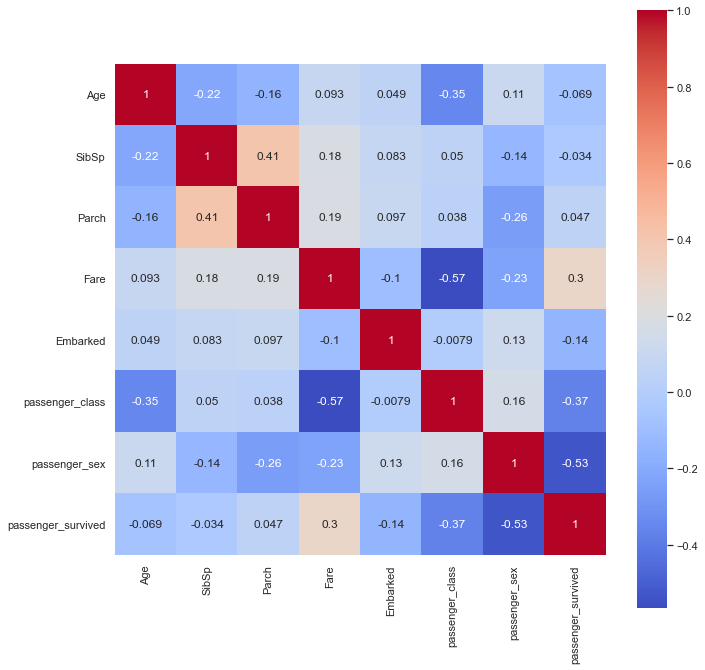

In [15]:
fig, ax = plt.subplots(figsize=(11,11))
sns.heatmap(train_set.drop('PassengerId', axis=1).corr(), cmap='coolwarm', annot=True, ax=ax, square=True)

Vemos que variables como la clase, el sexo, la tarifa y el puerto de embarcación tienen una correlación relativamente alta con la variable objetivo.

### Análisis visual
Intentaremos explorar los datos por medio de gráficas que puedan ser relevantes y brindar nueva información.

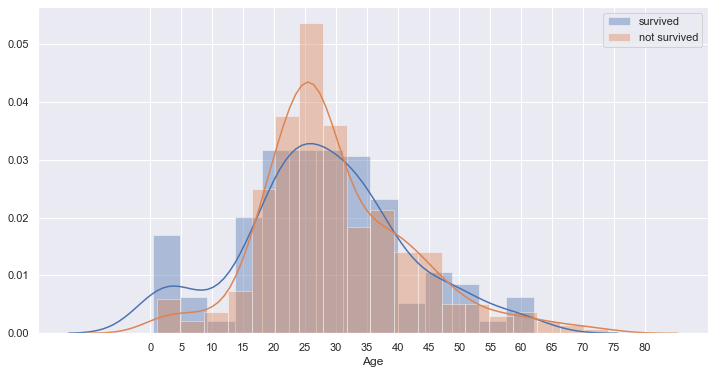

In [16]:
plt.figure(figsize=(12,6))
survived = train_set['passenger_survived'] == 1
sns.distplot(train_set[survived]["Age"],  label="survived")
sns.distplot(train_set[~survived]["Age"],  label="not survived")
plt.gca().set_xticks(range(0, 85, 5))


sns.distplot
plt.legend()
plt.show()

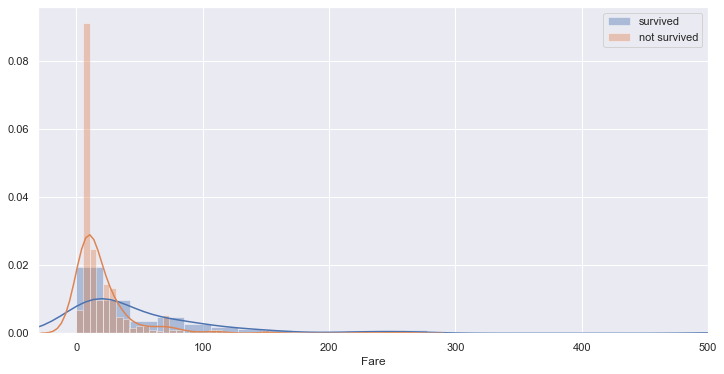

In [17]:
plt.figure(figsize=(12,6))
survived = train_set['passenger_survived'] == 1
sns.distplot(train_set[survived]["Fare"],  label="survived")
sns.distplot(train_set[~survived]["Fare"],  label="not survived")
plt.gca().set_xlim(-30, 500)
sns.distplot
plt.legend()
plt.show()

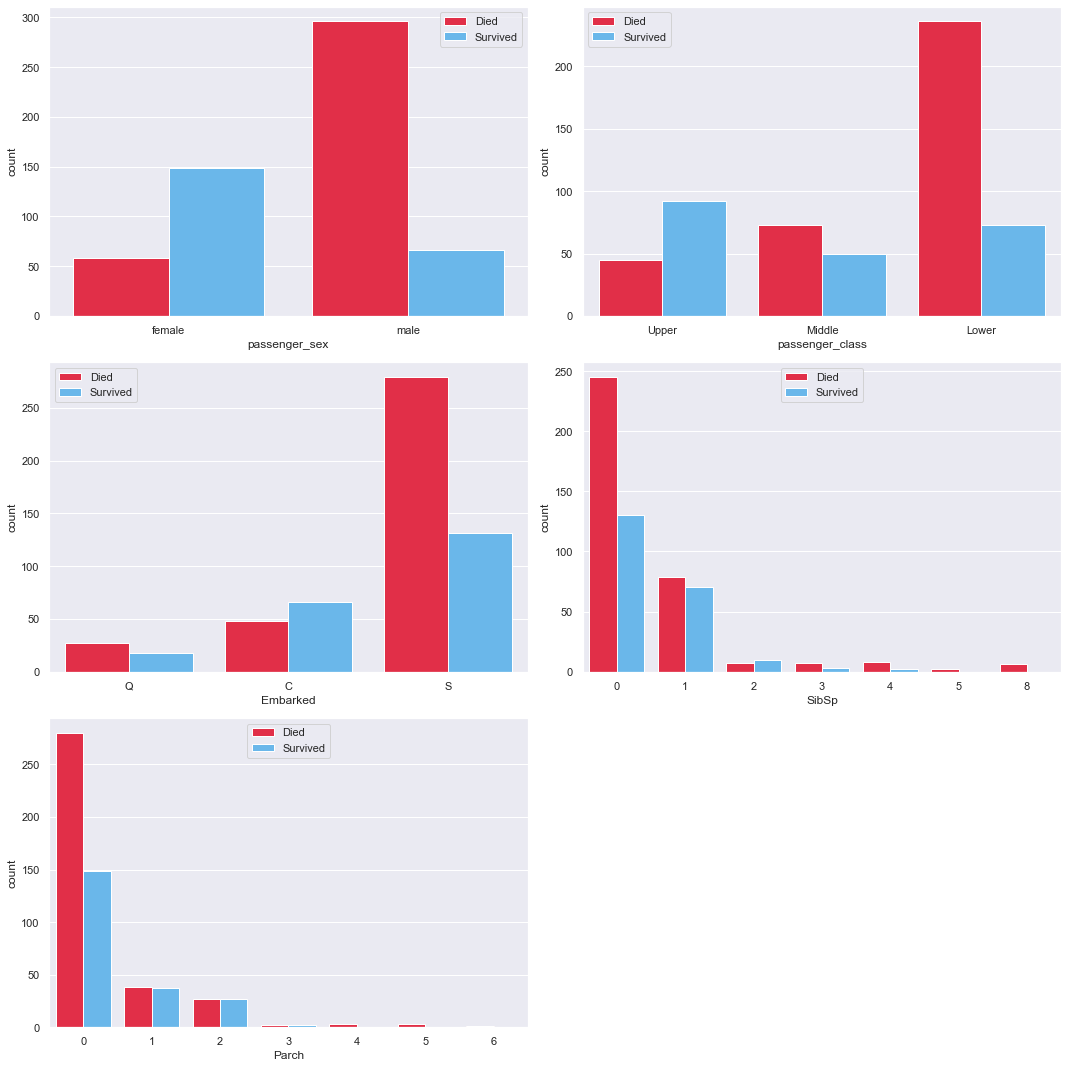

In [18]:
features = ['passenger_sex', 'passenger_class', 'Embarked', 'SibSp', 'Parch']
xticks = {'passenger_sex' : ['female', 'male'], 'passenger_class' : ['Upper', 'Middle', 'Lower'], 'Embarked' : ['Q', 'C', 'S']}

for i, feat in enumerate(features, 1):
    ax = plt.subplot(3,2,i)
    ax.get_figure().set_size_inches(15,15)
    cax = sns.countplot(x=feat, data=train_set, hue='passenger_survived', palette=['#f13', '#5bf'])
    plt.legend(['Died',  'Survived'])
    ticks = xticks.get(feat)
    if ticks:
        cax.set_xticklabels(ticks)

plt.tight_layout()
plt.show()

Vemos que existen diferentes tazas de mortalidad según la variable categórica.
* Más mortalidad en hombres que en mujeres
* Mucha más mortalidad en la clase baja que en la media y alta, solamente la clase alta tuvo más sobrevivientes que muertes.
* La mortalidad es más alta para pasajeros con Embarked=S 
* Mayor mortalidad en personas que viajaban sin padres/hijos ni pareja/hermanos.

## Feature Engineering

En el análisis anterior notamos que existe mayor mortalidad en personas que viajaban sin padres/hijos ni pareja/hermanos. Crearemos una variable que consista en la suma de ParCh y SibSp y veremos si mejora el desempeño del modelo al usarla. La creamos en todo el data set para que esté disponible en los datos de prueba/validación.

In [19]:
all_data['FamilyMembers'] = all_data['Parch'] + all_data['SibSp']
split_dataset()


## Modelos de predicción individuales

### Clasificador Naive Bayes

In [47]:
class NaiveBayes:
    def __init__(self, train_x, train_y, x_labels=None):
        self.x_labels = x_labels
        df = self.__init_dataframe(train_x, train_y)
        by_class = df.groupby('y')
        self.means = by_class.mean()
        self.stdvs = by_class.std()
        self.cdist = by_class['y'].count() / df.shape[0]

    def __init_dataframe(self, train_x, train_y):
        df = pd.DataFrame()
        df['y'] = train_y
        for i,x in enumerate(train_x):
            label = self.x_labels[i] if self.x_labels else 'x_' + str(i)
            df[label] = x
        return df

    def predict(self, x_samples):
        probs = []
        for y in self.cdist.index:
            mean = self.means.iloc[y].to_numpy()
            std = self.stdvs.iloc[y].to_numpy()
            p_x = self.norm_pdf(x_samples, mean, std)
            probs.append(self.cdist[y] * np.prod(p_x, axis=1))
        probs = np.asarray(probs)
        return np.argmax(probs.T,axis=1)

    def norm_pdf(self, x, mean, std):
        e = np.exp(-((x - mean)**2 / (2 * std**2 )))
        return (1 / (sqrt(2*pi) * std)) * e


In [80]:
def train_naive_bayes(x, y):
    if y.shape[0] != x.shape[1]:
        x = x.T
    nv = NaiveBayes(x,y)
    return nv

### Clasificador binario basado en regresión logísitca

In [85]:
  class BinaryLogisticRegression:
    def __init__(self, x, y):
        # Si x es unidimensional, convertir a columna. 
        # Si x es matriz, asumir una variable por columna.
        self.x = x.reshape(-1,1) if x.ndim == 1 else x 
        self.y = y.reshape(-1, 1)
        self.weights = None
        self.epochs = None 
        self.lr = None
        self.print_rate = None
        self.feed = None
        self.batch_size = None
        self.batch_iters = None
    
    def train(self, epochs, lr, batch_size, print_rate=10):
        self.print_rate = print_rate
        self.epochs = epochs
        self.lr = lr
        self.batch_size = min(batch_size, self.x.shape[0])
        self.batch_iters = int(self.x.shape[0]/self.batch_size)

        g = tf.Graph()
        with g.as_default():
            return self.__do_train()

    
    def __do_train(self):
        placeholder_x = tf.placeholder(tf.float64, [self.batch_size, self.x.shape[1]], "x")
        placeholder_y = tf.placeholder(tf.float64, [self.batch_size, self.y.shape[1]], "y")

        with tf.Session() as session:
            (weights_op, error_op) = self.__gradient_descent(placeholder_x, placeholder_y)
            self.before_training(session.graph, weights_op, error_op)
            session.run(tf.global_variables_initializer())    
            for epoch in range(1, self.epochs + 1):
                for i in range(self.batch_iters):
                    start_index  = i*self.batch_size
                    end_index = start_index + self.batch_size

                    x_batch = np.array(self.x[start_index:end_index])
                    y_batch = np.array(self.y[start_index:end_index])
                    self.feed = { placeholder_x: x_batch, placeholder_y: y_batch }


                    out = session.run([weights_op, error_op], self.feed)
                    self.error = out[1]
                    self.weights = out[0]
                self.after_epoch(epoch, session)

    def __gradient_descent(self, x, y):
        n_samples = x.shape[0]
        n_independent_vars = x.shape[1] + 1

        bias_feature = tf.ones([n_samples, 1], tf.float64)
        x = tf.concat([x, bias_feature], axis=1)

        initial_weights = tf.zeros([n_independent_vars, 1], tf.float64)
        weights = tf.Variable(name="Weights", initial_value=initial_weights)
        logits = tf.matmul(x, weights)
        error = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits,labels=y))
        gradients = tf.gradients(error, weights)
        adjustment = tf.scalar_mul(-self.lr, gradients[0])
        weights = tf.assign(weights, (tf.add(weights, adjustment)))
        return (weights, error)

    def after_epoch(self, epoch, session):
        if epoch % self.print_rate == 0 or epoch == self.epochs:
            print("epoch:" + str(epoch) + " error: " + str(self.error))
    
    def before_training(self, graph, weights_op, error_op):
        # overridear para inicializar tensorboard, etc
        pass

    def predict(self, x):
        x = np.hstack((x,np.ones((x.shape[0],1))))
        logits = np.matmul(x, self.weights)
        logits_ph = tf.placeholder(tf.float32, logits.shape)
        with tf.Session() as session:
            feed = {logits_ph: logits}
            probs = session.run(tf.nn.sigmoid(logits_ph), feed_dict=feed)
            session.close()
        y = np.array(list(map(lambda p: 1 if p > 0.5 else 0, probs)))
        return y

In [98]:

def train_logistic_regression(x, y, epochs, lr, batch_size, print_rate=1000):
    logreg = BinaryLogisticRegression(x,y)
    logreg.train(epochs, lr, batch_size, print_rate)
    return logreg


### Scikit Learn DecisionTreeClassifier 

In [24]:
def train_decision_tree(x, y):
    decision_tree = DecisionTreeClassifier()
    decision_tree.fit(x, y)
    return decision_tree

# gv_data = export_graphviz(decision_tree, out_file=None,
#                                         feature_names=["weather","temp"],
#                                         class_names=["not_play","play"],
#                                         filled=True, rounded=True,
#                                         special_characters=True)
# graph = graphviz.Source(gv_data)



### Scikit Learn Support Vector Machine Classifier

In [25]:
def train_svm(x,y):
    svm_classifier = svm.SVC(kernel='linear')
    svm_classifier.fit(x,y)
    return svm_classifier

## Entrenamiento de Modelos y Selección Final de Variables

### Bootstrapping

In [106]:
bootstrap_size = int(train_set.shape[0] * 0.82)
all_x_train = train_set.drop('passenger_survived', axis=1)
all_y_train = train_set['passenger_survived']
x_train1, y_train1 = resample(all_x_train, all_y_train, n_samples=bootstrap_size)
x_train2, y_train2 = resample(all_x_train, all_y_train, n_samples=bootstrap_size)
x_train3, y_train3 = resample(all_x_train, all_y_train, n_samples=bootstrap_size)
x_train4, y_train4 = resample(all_x_train, all_y_train, n_samples=bootstrap_size)

validation_y = validation_set['passenger_survived']

In [104]:
def score_model(model, x, y_real, dataset_type):
    y_pred = model.predict(x)
    metrics = pd.DataFrame()
    metrics['accuracy']  = [accuracy_score(y_real, y_pred)]
    metrics['precision'] = [precision_score(y_real, y_pred)]
    metrics['recall']    = [recall_score(y_real, y_pred)]
    metrics['f1']        = [f1_score(y_real, y_pred)]
    metrics['type']      = [dataset_type]

    n_errors = sum(map(lambda a,b: 1 if a!= b else 0, y_real, y_pred))
    metrics['error %'] = n_errors / len(y_real)

    return metrics.set_index('type')

### Naive Bayes

In [105]:
def train_and_score_nv(feature_names = ['Embarked', 'passenger_sex', 'Age']):
    nv_train_x = x_train1[feature_names].to_numpy()
    nv_train_y = y_train1.to_numpy()

    nv_model = train_naive_bayes(nv_train_x, nv_train_y)
    training_metrix = score_model(nv_model, nv_train_x, nv_train_y, 'training')

    nv_validation_x = validation_set[feature_names]
    validation_metrix = score_model(nv_model, nv_validation_x, validation_y, 'validation')

    print('Naive Bayes', '-', feature_names)
    return pd.concat([training_metrix, validation_metrix]), nv_model

train_and_score_nv()[0]

Naive Bayes - ['Embarked', 'passenger_sex', 'Age']


,accuracy,precision,recall,f1,error %
type,,,,,
training,0.751073,0.648810,0.656627,0.652695,0.248927
validation,0.818182,0.821429,0.741935,0.779661,0.181818


### Logistic Regression

In [100]:
def train_and_score_logreg(feature_names, epochs=8000, lr=0.01, batch_size=64):
    lr_train_x = x_train2[feature_names].to_numpy()
    lr_train_y = y_train2.to_numpy()

    logreg_model = train_logistic_regression(lr_train_x, lr_train_y, epochs, lr, batch_size, print_rate=2000)
    training_metrix = score_model(logreg_model, lr_train_x, lr_train_y, 'training')

    logreg_validation_x = validation_set[feature_names]
    validation_metrix = score_model(logreg_model, logreg_validation_x, validation_y, 'validation')

    confstr = 'lr='+str(lr)+'_epochs='+str(epochs)+'_batch_size='+str(batch_size)
    print('Logistic Regression', '-', feature_names, confstr)
    return pd.concat([training_metrix, validation_metrix]), logreg_model

train_and_score_logreg(['Embarked', 'passenger_sex', 'Age'])[0]

epoch:2000 error: 0.47158804312329233
epoch:4000 error: 0.47087931771527053
epoch:6000 error: 0.47082616045430026
epoch:8000 error: 0.4708186458032143
Logistic Regression - ['Embarked', 'passenger_sex', 'Age'] lr=0.01_epochs=8000_batch_size=64


,accuracy,precision,recall,f1
type,,,,
training,0.757511,0.675000,0.639053,0.656535
validation,0.818182,0.833333,0.725806,0.775862


In [99]:
train_and_score_logreg(['Embarked', 'passenger_sex', 'Age', 'FamilyMembers'])[0]

epoch:2000 error: 0.47017879119330835
epoch:4000 error: 0.4687475186032929
epoch:6000 error: 0.46856405023133363
epoch:8000 error: 0.46852961791963244
Logistic Regression - ['Embarked', 'passenger_sex', 'Age', 'FamilyMembers'] lr=0.01_epochs=8000_batch_size=64


,accuracy,precision,recall,f1
type,,,,
training,0.768240,0.713287,0.603550,0.653846
validation,0.811189,0.857143,0.677419,0.756757


In [107]:
train_and_score_logreg(['passenger_sex', 'Age', 'FamilyMembers'])[0]

epoch:2000 error: 0.4988453108052323
epoch:4000 error: 0.5028975502306094
epoch:6000 error: 0.5037214533863381
epoch:8000 error: 0.5038648212732092
Logistic Regression - ['passenger_sex', 'Age', 'FamilyMembers'] lr=0.01_epochs=8000_batch_size=64


,accuracy,precision,recall,f1,error %
type,,,,,
training,0.776824,0.790323,0.556818,0.653333,0.223176
validation,0.797203,0.883721,0.612903,0.723810,0.202797


In [109]:
train_and_score_logreg(['Embarked', 'passenger_sex', 'Age', 'FamilyMembers'], batch_size=128)[0]

epoch:2000 error: 0.5146807480296429
epoch:4000 error: 0.5139195374252288
epoch:6000 error: 0.5154618676431791
epoch:8000 error: 0.5168051546520174
Logistic Regression - ['Embarked', 'passenger_sex', 'Age', 'FamilyMembers'] lr=0.01_epochs=8000_batch_size=128


,accuracy,precision,recall,f1,error %
type,,,,,
training,0.789700,0.743750,0.676136,0.708333,0.210300
validation,0.832168,0.865385,0.725806,0.789474,0.167832


In [122]:
train_and_score_logreg(['Embarked', 'passenger_sex', 'Age', 'FamilyMembers', 'passenger_class'], batch_size=128)[0]

epoch:2000 error: 0.4264102087465825
epoch:4000 error: 0.39472177013131043
epoch:6000 error: 0.37866312695603055
epoch:8000 error: 0.3696653209713091
Logistic Regression - ['Embarked', 'passenger_sex', 'Age', 'FamilyMembers', 'passenger_class'] lr=0.01_epochs=8000_batch_size=128


,accuracy,precision,recall,f1,error %
type,,,,,
training,0.830472,0.859259,0.659091,0.745981,0.169528
validation,0.832168,0.895833,0.693548,0.781818,0.167832


In [123]:
train_and_score_logreg(['Embarked', 'passenger_sex', 'Age', 'FamilyMembers', 'passenger_class', 'Fare'], batch_size=128)[0]

epoch:2000 error: 0.439283843491649
epoch:4000 error: 0.40092100684740123
epoch:6000 error: 0.38405069166538947
epoch:8000 error: 0.37350699347350996
Logistic Regression - ['Embarked', 'passenger_sex', 'Age', 'FamilyMembers', 'passenger_class', 'Fare'] lr=0.01_epochs=8000_batch_size=128


,accuracy,precision,recall,f1,error %
type,,,,,
training,0.802575,0.747059,0.721591,0.734104,0.197425
validation,0.811189,0.818182,0.725806,0.769231,0.188811


In [118]:
train_and_score_logreg(['Embarked', 'passenger_sex', 'Age', 'FamilyMembers', 'Fare'], batch_size=128)[0]

epoch:2000 error: 0.44593371682502425
epoch:4000 error: 0.4278212488295678
epoch:6000 error: 0.4314875915613235
epoch:8000 error: 0.43728265303663194
Logistic Regression - ['Embarked', 'passenger_sex', 'Age', 'FamilyMembers', 'Fare'] lr=0.01_epochs=8000_batch_size=128


,accuracy,precision,recall,f1,error %
type,,,,,
training,0.778970,0.693122,0.744318,0.717808,0.221030
validation,0.804196,0.774194,0.774194,0.774194,0.195804


### Decision Tree

In [121]:
def train_and_score_tree(feature_names):
    tree_train_x = x_train3[feature_names].to_numpy()
    tree_train_y = y_train3.to_numpy()

    tree_model = train_decision_tree(tree_train_x, tree_train_y)
    training_metrix = score_model(tree_model, tree_train_x, tree_train_y, 'training')

    tree_validation_x = validation_set[feature_names]
    validation_metrix = score_model(tree_model, tree_validation_x, validation_y, 'validation')

    print('Decision Tree', '-', feature_names)
    return pd.concat([training_metrix, validation_metrix]), tree_model

train_and_score_tree(['Embarked', 'passenger_sex', 'Age', 'FamilyMembers'])[0]

Decision Tree - ['Embarked', 'passenger_sex', 'Age', 'FamilyMembers']


,accuracy,precision,recall,f1,error %
type,,,,,
training,0.920601,0.98125,0.821990,0.894587,0.079399
validation,0.776224,0.80000,0.645161,0.714286,0.223776


In [117]:
train_and_score_tree(['Embarked', 'passenger_sex', 'Age', 'Fare'])[0]

Decision Tree - ['Embarked', 'passenger_sex', 'Age', 'Fare']


,accuracy,precision,recall,f1,error %
type,,,,,
training,0.980687,0.989247,0.963351,0.976127,0.019313
validation,0.790210,0.785714,0.709677,0.745763,0.209790


In [119]:
train_and_score_tree(['Embarked', 'passenger_sex', 'Age', 'passenger_class'])[0]

Decision Tree - ['Embarked', 'passenger_sex', 'Age', 'passenger_class']


,accuracy,precision,recall,f1,error %
type,,,,,
training,0.920601,0.963855,0.837696,0.896359,0.079399
validation,0.832168,0.851852,0.741935,0.793103,0.167832


In [124]:
train_and_score_tree(['Embarked', 'passenger_sex', 'Age', 'passenger_class', 'Fare'])[0]

Decision Tree - ['Embarked', 'passenger_sex', 'Age', 'passenger_class', 'Fare']


,accuracy,precision,recall,f1,error %
type,,,,,
training,0.980687,0.989247,0.963351,0.976127,0.019313
validation,0.783217,0.762712,0.725806,0.743802,0.216783


### SVM

In [125]:
def train_and_score_svm(feature_names):
    svm_train_x = x_train4[feature_names].to_numpy()
    svm_train_y = y_train4.to_numpy()

    svm_model = train_svm(svm_train_x, svm_train_y)
    training_metrix = score_model(svm_model, svm_train_x, svm_train_y, 'training')

    svm_validation_x = validation_set[feature_names]
    validation_metrix = score_model(svm_model, svm_validation_x, validation_y, 'validation')

    print('SVM', '-', feature_names)
    return pd.concat([training_metrix, validation_metrix]), svm_model

train_and_score_svm(['Embarked', 'passenger_sex', 'Age', 'FamilyMembers'])[0]

SVM - ['Embarked', 'passenger_sex', 'Age', 'FamilyMembers']


,accuracy,precision,recall,f1,error %
type,,,,,
training,0.774678,0.708861,0.654971,0.680851,0.225322
validation,0.825175,0.836364,0.741935,0.786325,0.174825


In [126]:
train_and_score_svm(['Embarked', 'passenger_sex', 'Age', 'FamilyMembers', 'passenger_class'])[0]

SVM - ['Embarked', 'passenger_sex', 'Age', 'FamilyMembers', 'passenger_class']


,accuracy,precision,recall,f1,error %
type,,,,,
training,0.774678,0.708861,0.654971,0.680851,0.225322
validation,0.825175,0.836364,0.741935,0.786325,0.174825


In [127]:
train_and_score_svm(['Embarked', 'passenger_sex', 'Age', 'FamilyMembers', 'passenger_class', 'Fare'])[0]

SVM - ['Embarked', 'passenger_sex', 'Age', 'FamilyMembers', 'passenger_class', 'Fare']


,accuracy,precision,recall,f1,error %
type,,,,,
training,0.774678,0.708861,0.654971,0.680851,0.225322
validation,0.825175,0.836364,0.741935,0.786325,0.174825


In [131]:
train_and_score_svm(['Embarked', 'passenger_sex', 'Age'])[0]

SVM - ['Embarked', 'passenger_sex', 'Age']


,accuracy,precision,recall,f1,error %
type,,,,,
training,0.774678,0.708861,0.654971,0.680851,0.225322
validation,0.825175,0.836364,0.741935,0.786325,0.174825
